# Custom Landscape: São Tomé

In [19]:
# Fix PROJ path ---------------------------------------------------------------
import os; os.environ['PROJ_LIB']='/path/to/env/share/proj'
# Load libraries --------------------------------------------------------------
from os import path
import numpy as np
import pandas as pd
import MGSurvE as srv
from copy import deepcopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from numpy.random import uniform
from sklearn.preprocessing import normalize
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('customLanscape', './out/')
(ptsPath, migPath) = (
    path.join('../../data/GEO', 'STP_LatLon.csv'),
    path.join('../../data/GEO', 'STP_Migration.csv')
)
srv.makeFolder(OUT_PTH)

In [20]:
SAO_TOME_LL = pd.read_csv(ptsPath)
SAO_TOME_MIG = np.genfromtxt(migPath, delimiter=',')
# Calculate centrer and bounding box ------------------------------------------
SAO_bbox = (
    (min(SAO_TOME_LL['lon']), max(SAO_TOME_LL['lon'])),
    (min(SAO_TOME_LL['lat']), max(SAO_TOME_LL['lat']))
)
SAO_cntr = [i[0]+(i[1]-i[0])/2 for i in SAO_bbox]
SAO_LIMITS = ((6.41, 6.79), (-0.0475, .45))
# Row-normalize migration matrix ----------------------------------------------
SAO_TOME_MIG = normalize(SAO_TOME_MIG, axis=1, norm='l1')

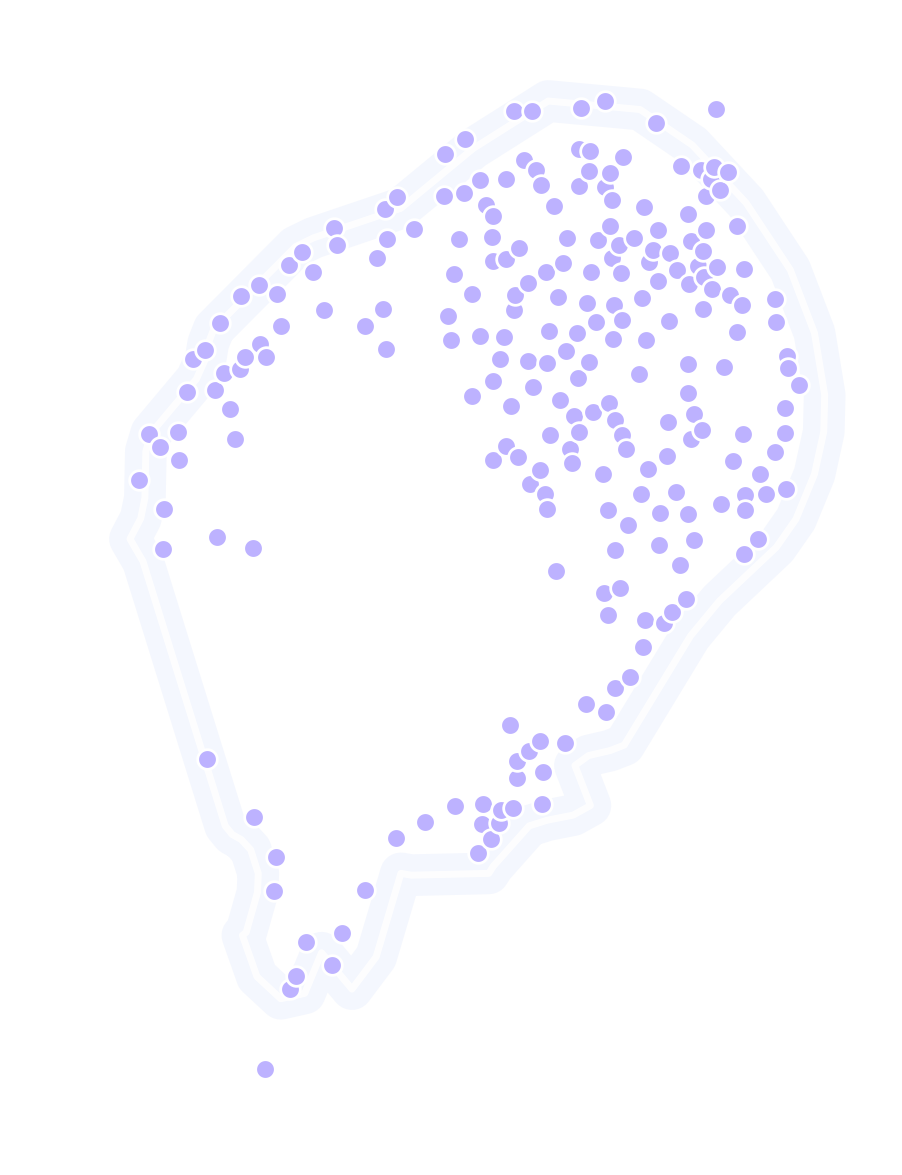

In [21]:
# Land creation ---------------------------------------------------------------
lnd = srv.Landscape(
    SAO_TOME_LL, 
    migrationMatrix=SAO_TOME_MIG,
    landLimits=SAO_LIMITS,
)
# Plots -----------------------------------------------------------------------
bbox = lnd.getBoundingBox()
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=200)
lnd.plotLandBoundary(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    os.path.join(OUT_PTH, '{}.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

### Exporting landscape

To export our generated landscape to disk, we can simply call one of our helper functions:

In [22]:
srv.dumpLandscape(lnd, OUT_PTH, '{}_LND'.format(ID), fExt='pkl')

To re-load it for mode analyisis down the line, we can call:

In [23]:
lnd = srv.loadLandscape(OUT_PTH, '{}_LND'.format(ID), fExt='pkl')

## Optimization

In [24]:
TRPS_NUM = 10
# Defining Traps --------------------------------------------------------------
(initTyp, initFxd, initLon, initLat) = (
    [0]*TRPS_NUM, [False]*TRPS_NUM,
    uniform(*SAO_bbox[0], TRPS_NUM), uniform(*SAO_bbox[1], TRPS_NUM)
)
sid = [0]*(TRPS_NUM) 
traps = pd.DataFrame({
    'sid': sid,
    'lon': initLon, 'lat': initLat, 
    't': initTyp, 'f': initFxd
})
tKer = {0: {'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}
# Updating Landscape ----------------------------------------------------------
lnd.updateTraps(traps=traps, trapsKernels=tKer)
lnd.trapsSiteID = traps['sid'] # NEED TO FIX THIS IN PKG

In [25]:
# GA Settings -----------------------------------------------------------------
(GENS, POP_SIZE, VERBOSE) = (25, int(10*(lnd.trapsNumber*1.5)), True)
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)

In [26]:
# Setup and Run GA ------------------------------------------------------------
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lnd, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    optimFunction=srv.getDaysTillTrappedPseudoInverse,
    fitFuns={'inner': np.sum, 'outer': np.mean}
)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min        	avg        	max        	std        	best	traps                                           
0  	150   	1.30379e+13	3.32081e+14	6.00737e+15	5.00476e+14	28  	[236, 107, 196, 221, 196, 120, 56, 136, 17, 224]
1  	75    	1232.38    	2.12527e+14	3.16831e+14	1.1196e+14 	126 	[66, 19, 84, 113, 24, 212, 125, 132, 83, 123]   
2  	96    	1232.38    	1.91283e+14	1.54831e+15	1.99093e+14	145 	[66, 19, 84, 113, 24, 212, 125, 132, 83, 123]   
3  	68    	1188.77    	1.28301e+14	1.81821e+15	2.28596e+14	111 	[184, 11, 232, 169, 105, 212, 200, 24, 202, 68] 
4  	85    	1188.77    	9.74273e+13	5.29135e+14	1.27137e+14	127 	[184, 11, 232, 169, 105, 212, 200, 24, 202, 68] 
5  	87    	1188.77    	1.12112e+14	1.39742e+15	1.71145e+14	40  	[184, 11, 232, 169, 105, 212, 200, 24, 202, 68] 
6  	75    	1188.77    	9.02482e+13	1.33531e+15	1.5716e+14 	15  	[184, 11, 232, 169, 105, 212, 200, 24, 202, 68] 
7  	87    	1117.92    	8.90761e+13	7.13454e+14	1.30698e+14	135 	[124, 11, 232, 169, 105, 212, 20

(<Figure size 1500x1500 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x28ec36a40>)

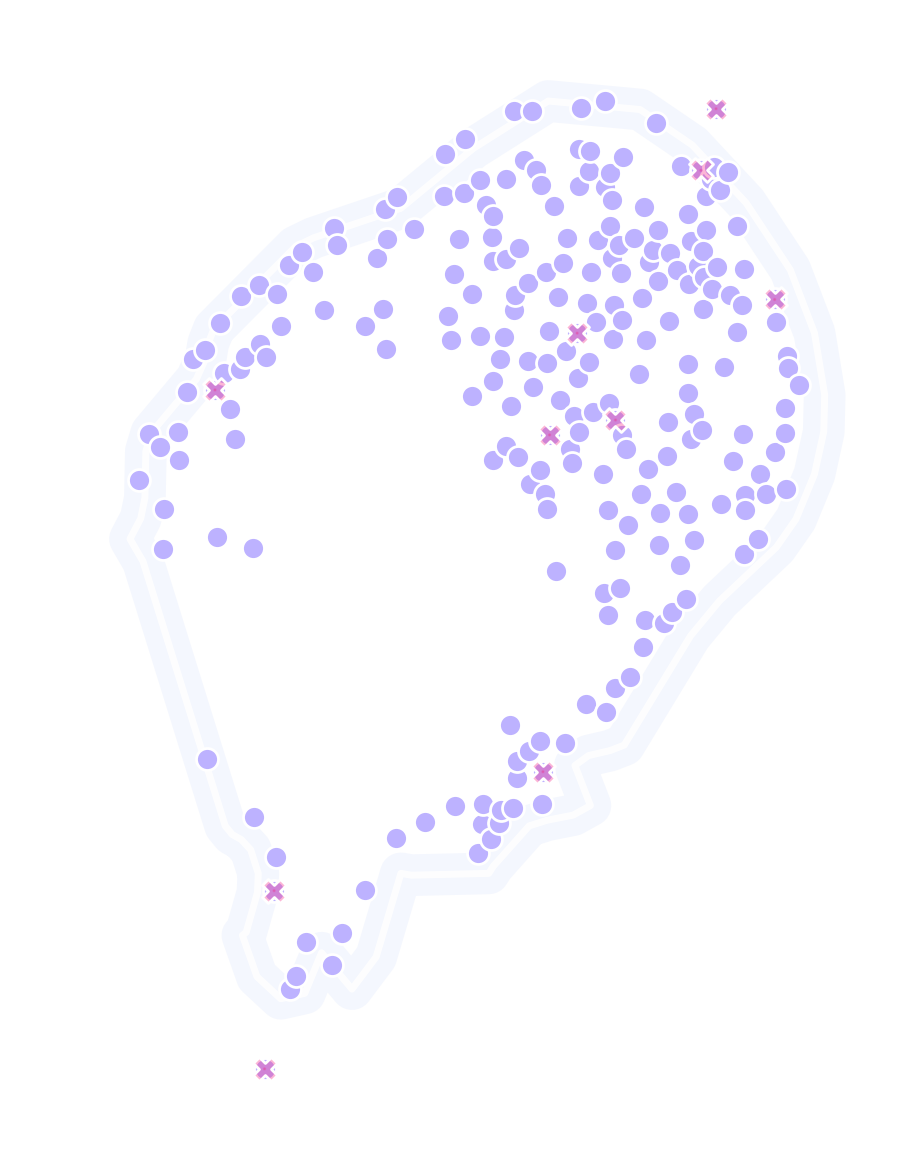

In [27]:
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
# lnd.plotMigrationNetwork(
#     fig, ax, lineWidth=30, alphaMin=.25, alphaAmplitude=2.5
# )
lnd.plotTraps(
    fig, ax, 
    zorders=(30, 25), transparencyHex='55', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
# srv.plotFitness(fig, ax, min(dta['min']), fmt='{:.2f}')
lnd.plotLandBoundary(fig, ax)